In [1]:
import pandas as pd
from transformers import BertTokenizer
import torch
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [2]:
def load_data(file_path):
    """Load dataset from a file path."""
    df = pd.read_csv(file_path)
    columns_to_keep = ['Customer Review', 'Emotion']
    return df[columns_to_keep]

def clean_text(df):
    # Lowercase conversion if using an uncased model
    df['Customer Review'] = df['Customer Review'].str.lower()
    
    # Remove extra whitespaces
    df['Customer Review'] = df['Customer Review'].str.strip().replace(r'\s+', ' ', regex=True)
    return df

def encode_labels(df):
    """Encode emotion labels."""
    label_encoder = LabelEncoder()
    df['Emotion'] = label_encoder.fit_transform(df['Emotion'])
    return df, label_encoder.classes_

def visualize_tokens_len(df, tokenizer):
    """Visualize the distribution of token lengths in the dataset."""
    token_lens = []

    for txt in df['Customer Review']:
        tokens = tokenizer.encode(txt, max_length=512, truncation=True)
        token_lens.append(len(tokens))
        
    sns.histplot(token_lens, kde=False)
    plt.xlim([0, 256])
    plt.xlabel('Token count')
    plt.ylabel('Number of reviews')
    plt.title('Distribution of Review Token Lengths')
    plt.show()

def preprocess_data(df, tokenizer):
    """Preprocess data using the provided tokenizer."""
    
    encoded_data = tokenizer.batch_encode_plus(
        df['Customer Review'].values, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        max_length=MAX_LEN,  # Use the global variable
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(df['Emotion'].values)
    
    # Save the tensors to file
    torch.save(input_ids, 'input_ids.pt')
    torch.save(attention_masks, 'attention_masks.pt')
    torch.save(labels, 'labels.pt')


In [3]:
file_path = "https://raw.githubusercontent.com/marceljonathan/natural-language-processing/main/PRDECT-ID%20Dataset.csv"  # Update this to your dataset's path
original_df = load_data(file_path)
original_df.head()

,Customer Review,Emotion
0,Alhamdulillah berfungsi dengan baik. Packaging aman. Respon cepat dan ramah. Seller dan kurir amanah,Happy
1,"barang bagus dan respon cepat, harga bersaing dengan yg lain.",Happy
2,"barang bagus, berfungsi dengan baik, seler ramah, pengiriman cepat",Happy
3,bagus sesuai harapan penjual nya juga ramah. trimakasih pelapak ??,Happy
4,"Barang Bagus, pengemasan Aman, dapat Berfungsi dengan Baik",Happy


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


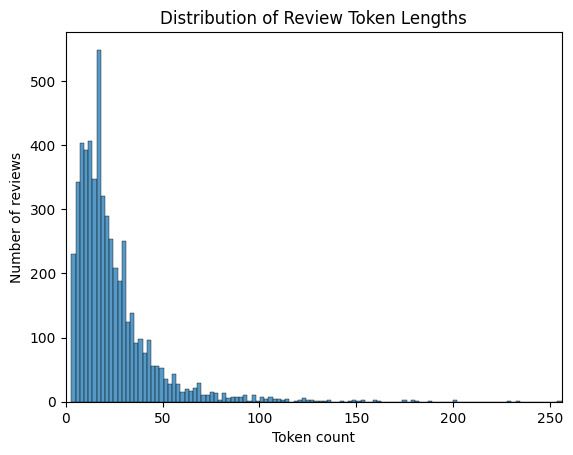

In [4]:
df = clean_text(original_df)
df, label_classes = encode_labels(df)
tokenizer_model = 'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(tokenizer_model)

visualize_tokens_len(df, tokenizer)

In [5]:
MAX_LEN = 128 # Based on the distribution

In [6]:
preprocess_data(df, tokenizer)

# Optionally, save the mapping of encoded labels to emotions to a file
pd.Series(label_classes).to_csv('label_classes.csv', index=False)